In [1]:
import tensorflow as tf
import numpy as np
import os

os.environ["CUDA_VISIBLE_DEVICES"]=str("2")


In [2]:
FF_input_scale = tf.exp(tf.Variable(np.zeros(4,dtype = np.float32),name = "feedforward_inp"))*np.float32(np.array([1,1,0,0]))
LAT_input_scale = tf.exp(tf.Variable(np.zeros(4,dtype = np.float32),name = "lateral_inp"))

#FB_input_scale = tf.exp(-tf.Variable(np.ones(4,dtype = np.float32),name = "feeedback_inp"))
FB_input_scale = tf.exp(tf.Variable(np.float32(np.log([12.8,24,8,9.6])-5),name = "feedback_inp"))
AR_input_scale = (tf.exp(tf.Variable(np.ones(4,dtype = np.float32),name = "arousal_inp")) - 1)*FB_input_scale

#FB_input_scale = 0.
#AR_input_scale = tf.exp(tf.Variable(np.ones(4,dtype = np.float32),name = "feeedback_inp"))

ff_lam = tf.exp(tf.Variable(np.float32(np.log(10.)),name = "feedforward_shape_parameter"))
lat_lam = tf.exp(tf.Variable(np.float32(np.log(10.)),name = "lateral_shape_parameter"))

input_size = tf.placeholder(tf.float32,shape = [None,1])
input_arousal = tf.placeholder(tf.float32,shape = [None,1])

In [3]:
def lat_input(R):
    return 1. - tf.exp(-tf.abs(R)/lat_lam)
    #return tf.nn.sigmoid(R - lat_lam)
def ff_input(R):
    return tf.erf(tf.abs(R)/ff_lam)

In [4]:

dt = .001
tau_E = .02
tau_I = .01

tau = np.float32(np.array([tau_E,tau_I,tau_I,tau_I]))

n = 2.2
k = tf.exp(tf.Variable(np.float32(np.log(.1)),trainable = True,name = "k"))

T = 1.
nt = int(T/dt)

W = np.float32(np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]]))*tf.exp(tf.Variable(np.log(np.float32(np.array([[.017,.956,.045,.512],
              [.8535,.99,.09,.307],
              [2.104,.184,1,.734],
              [1.285,1,.14,1]]))) - 3,trainable = True,name = "W"))


In [5]:
MAX_RATE = 1000

def ssn_nonlinearity(V,n):
    return tf.pow(tf.clip_by_value(V,clip_value_min = 0,clip_value_max = MAX_RATE),n)

def get_next_SSN_state(state,A,lat_inp,ff_inp,W,k,n,tau,dt):
    ffI = ff_inp *  tf.expand_dims(FF_input_scale,0)
    laI = lat_inp * tf.expand_dims(LAT_input_scale,0)
    fbI = tf.expand_dims(FB_input_scale,0) + A * tf.expand_dims(AR_input_scale,0)
   
    Vi = tf.tensordot(state,W,axes = [[1],[1]]) + ffI + laI + fbI
    R = k*ssn_nonlinearity(Vi,n)

    
    return state + dt*(-state + R)/tf.expand_dims(tau,0)
    
init_state = tf.tile(0*input_size,(1,4))

states = tf.scan(lambda x,i: get_next_SSN_state(x,
                                              input_arousal,
                                              lat_input(input_size),
                                              ff_input(input_size),
                                              W,
                                              k,
                                              n,
                                              tau,
                                              dt),
                 tf.range(nt),init_state)
states = tf.transpose(states,[1,0,2])
print(states.shape)
                     

(?, 1000, 4)


In [6]:
test_time = .1
test_nt = int(test_time/dt)

target_rates = tf.placeholder(tf.float32,(None,4))
loss = tf.reduce_mean((tf.expand_dims(target_rates,1) - states[:,-test_nt:])**2)
adam = tf.train.AdamOptimizer(learning_rate = .01)
train = adam.minimize(loss)

In [7]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [float(t) for t in l.split(",")]
        out.append(temp)
    F.close()
    return np.array(out)

PYR_targets = load("./DiPoppaData/Pyr_DiPoppa.csv")
PVAL_targets = load("./DiPoppaData/Pvalb_DiPoppa.csv")
SOM_targets = load("./DiPoppaData/SOM_DiPoppa.csv")
VIP_targets = load("./DiPoppaData/ViP_DiPoppa.csv")

data_names = ["Pyramidal","Parvalubin","ViP","Somatostatin"]

PYR_targets.shape

data = np.stack([PYR_targets,PVAL_targets,VIP_targets,SOM_targets],-1)
data = np.reshape(data,[2,10,2,4])

data_stim_size = data[:,:,0,0]
data_response = data[:,:,1,:]
data_arousal = np.stack([np.zeros_like(data[0,:,0,0]),np.ones_like(data[0,:,0,0])],0)

data_stim_size = np.float32(np.reshape(data_stim_size,[-1,1]))
data_arousal = np.float32(np.reshape(data_arousal,[-1,1]))
data_response = np.float32(np.reshape(data_response,[-1,4]))

[[ 0.00084638 -0.04759643 -0.00224042 -0.02549098]
 [ 0.04249326 -0.0492892  -0.00448084 -0.01528463]
 [ 0.10475198 -0.00916082  0.         -0.0365437 ]
 [ 0.06397638  0.         -0.00697019  0.        ]]
(2, 10, 4)


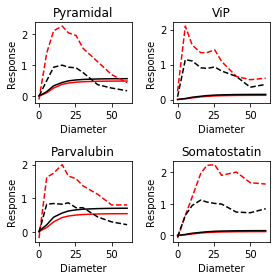

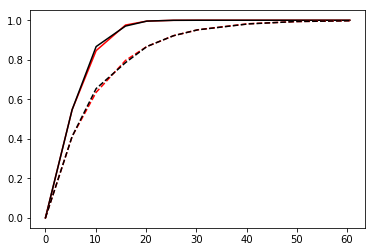

In [8]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

responses,latin,ffin,ww = sess.run([states,lat_input(input_size),
                                              ff_input(input_size),W],{input_arousal:data_arousal,input_size:data_stim_size})

print(ww)
OUT = np.mean(np.reshape(responses[:,-test_nt:],[2,10,-1,4]),axis = 2)
print(OUT.shape)
true_resp = np.reshape(data_response,[2,10,4])

latin = np.reshape(latin,[2,10])
ffin = np.reshape(ffin,[2,10])

import matplotlib.pyplot as plt

fig,sub = plt.subplots(2,2,figsize = (4,4))

for i in range(2):
    for j in range(2):
        sub[i,j].plot(data_stim_size[:10],OUT[0,:,i + 2*j],"r")
        sub[i,j].plot(data_stim_size[:10],OUT[1,:,i + 2*j],"k")
        
        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"r--")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"k--")
        sub[i,j].set_title(data_names[i+2*j])
        sub[i,j].set_xlabel("Diameter")
        sub[i,j].set_ylabel("Response")


plt.tight_layout()
plt.show()

plt.plot(data_stim_size[:10],ffin[0,:],"r")
plt.plot(data_stim_size[:10],ffin[1,:],"k")
plt.plot(data_stim_size[:10],latin[0,:],"r--")
plt.plot(data_stim_size[:10],latin[1,:],"k--")
plt.show()
sess.close()

In [9]:
variables = tf.trainable_variables()
vnames = [v.name for v in variables]

print(vnames)

['feedforward_inp:0', 'lateral_inp:0', 'feedback_inp:0', 'arousal_inp:0', 'feedforward_shape_parameter:0', 'lateral_shape_parameter:0', 'k:0', 'W:0']


In [10]:
init = tf.global_variables_initializer()
#config = tf.ConfigProto(device_count = {'GPU': 1})
#sess = tf.Session(config=config)
sess = tf.Session()
sess.run(init)

for k in range(1000):
    _,train_loss = sess.run([train,loss],{input_arousal:data_arousal,input_size:data_stim_size,target_rates:data_response})
    if k%10 == 0:
        print("{}\t{}".format(k,train_loss))
        
responses = sess.run(states,{input_arousal:data_arousal,input_size:data_stim_size})

parameters = sess.run(variables)

0	0.9758963584899902
10	0.8663613796234131
20	0.7606677412986755
30	0.6607081890106201
40	0.5528415441513062
50	0.45425885915756226
60	0.39797723293304443
70	0.3618915379047394
80	0.33606821298599243
90	0.31812989711761475
100	0.3058471977710724
110	0.29689112305641174
120	0.29007285833358765
130	0.28470268845558167
140	0.2803492546081543
150	0.2767469584941864
160	0.2737046778202057
170	0.27108684182167053
180	0.26879096031188965
190	0.2667383849620819
200	0.26486536860466003
210	0.2631186544895172
220	0.26145124435424805
230	0.25981926918029785
240	0.2581794261932373
250	0.25648579001426697
260	0.2546868920326233
270	0.252722829580307
280	0.25052154064178467
290	0.24799680709838867
300	0.24504895508289337
310	0.24157482385635376
320	0.23749585449695587
330	0.23281681537628174
340	0.22771547734737396
350	0.22260212898254395
360	0.21797195076942444
370	0.2139090895652771
380	0.20973257720470428
390	0.2045520395040512
400	0.19789350032806396
410	0.18961894512176514
420	0.180023461580276

In [11]:
sess.close()

In [12]:
responses.shape

(20, 1000, 4)

In [13]:
OUT = np.mean(np.reshape(responses[:,-test_nt:],[2,10,-1,4]),axis = 2)
print(OUT.shape)
true_resp = np.reshape(data_response,[2,10,4])

(2, 10, 4)


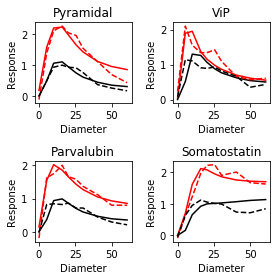

In [14]:
import matplotlib.pyplot as plt

fig,sub = plt.subplots(2,2,figsize = (4,4))

for i in range(2):
    for j in range(2):
        sub[i,j].plot(data_stim_size[:10],OUT[0,:,i + 2*j],"r")
        sub[i,j].plot(data_stim_size[:10],OUT[1,:,i + 2*j],"k")
        
        sub[i,j].plot(data_stim_size[:10],true_resp[0,:,i + 2*j],"r--")
        sub[i,j].plot(data_stim_size[:10],true_resp[1,:,i + 2*j],"k--")
        sub[i,j].set_title(data_names[i+2*j])
        sub[i,j].set_xlabel("Diameter")
        sub[i,j].set_ylabel("Response")


plt.tight_layout()
plt.savefig("./initial_multi_cell_fit.pdf",bbox_inches = "tight")
plt.show()

In [15]:
import utilities as utils 

utils.dump_file("./parameter_file",parameters)
utils.dump_file("./parameter_names",vnames)

In [16]:
parameters[-1]

array([[ 0.40848023, -4.8505807 , -0.92807335,  0.20382394],
       [ 0.0394574 , -4.2240715 , -3.6442003 , -0.10350509],
       [ 0.6684318 , -6.111399  , -3.        ,  0.59552723],
       [-0.31398678, -3.        , -6.426245  , -3.        ]],
      dtype=float32)

In [19]:
np.round(np.float32(np.array([[1,1,1,1],[1,1,1,1],[1,1,0,1],[1,0,1,0]])*np.array([[1,-1,-1,-1]]))*np.exp(parameters[-1]),3)

array([[ 1.505, -0.008, -0.395, -1.226],
       [ 1.04 , -0.015, -0.026, -0.902],
       [ 1.951, -0.002,  0.   , -1.814],
       [ 0.731,  0.   , -0.002,  0.   ]], dtype=float32)

In [23]:
np.array([[1,-1,-1,-1]])*np.array([
[.017,.956,.045,.512],
[.8535,.99,.09,.307],
[2.104,.184,0,.734],
[1.285,0,.14,0]
])

array([[ 0.017 , -0.956 , -0.045 , -0.512 ],
       [ 0.8535, -0.99  , -0.09  , -0.307 ],
       [ 2.104 , -0.184 , -0.    , -0.734 ],
       [ 1.285 , -0.    , -0.14  , -0.    ]])

In [25]:
vnames

['feedforward_inp:0',
 'lateral_inp:0',
 'feedback_inp:0',
 'arousal_inp:0',
 'feedforward_shape_parameter:0',
 'lateral_shape_parameter:0',
 'k:0',
 'W:0']

In [27]:
print(np.exp(parameters[-4]))
print(np.exp(parameters[-3]))

11.317467
19.59946


In [28]:
print(np.exp(parameters[-2]))

0.23472294
